# Monte Carlo simulation of SIS epidemic spreading
Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: Susceptible (S), i.e., healthy but can get infected; Infected (I), i.e., has the disease and can spread it to its neighbors. <br><br>

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease β (at least 51 values between β=0 and β=1, Δβ=0.02), for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). 


### Import libraries

In [1]:
import igraph as ig
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (12, 6)

# import cython module for allowing c compilation and static binding to improve the performance
%load_ext cython

Be sure to insall the Cython extension!

### Simulation function
The function below performs 1 full simulation of SIS epidemic spreading. <br>
Since this function is very expensive and it needs to be called at each performed simulation, we declare it as a c function and we add also some static binding for some of the used variables. <br>
In this way we greatly improve the performance of the algorithm. <br><br>
The simulation function takes in input:
* the graph g and its length
* the array of initial states (randomly generated): it is an array of the same size as the one of the network, where each cell indicates the state of the corresponding node (1 stands for I and 0 stands for S)
* the 2 main paramters of the SIS model, i.e. µ and β

The function performs TMAX iterations and it returns the average of ρ(t) calcualating considering the mean of the ρ values obtained after TTRANS iterations, when we assume that the systems has 
reached the stationary state. <br>

Indeed, the simulation requires also 2 extra parameters:
* TMAX  maximum number of time steps of each simulation
* TTRANS  number of steps of the transitory

In [2]:
%%cython
import numpy as np
import igraph as ig
from libc.math cimport pow # import C pow function
from libc.stdlib cimport rand, srand, RAND_MAX # import C random functions
from libc.time cimport time,time_t # import C time function

def simulation(g, int len_g, char[:] state, double mu, double beta):
    
    """
    Applies one simulation to the graph in argument and returns 
    the average infection rate over the stationary time steps
    """ 
    
    # Constants
    cdef int TMAX = 1000 # maximum number of time steps of each simulation
    cdef int TTRANS = 900 # number of steps of the transitory
    cdef double _beta = 1 - beta
    
    # Declared variables
    cdef double[:] infected_ratio_list = np.zeros(TMAX - TTRANS) # infection ratio at each step of the stationary
    cdef int i, j, v, n # counters
    cdef int infected_vertices # number of infected neighbors
    cdef char[:] old_state = np.zeros(len_g, dtype = np.int8) # array of the states of the nodes in the previous iteration
    cdef double prob # probability value between 0 and 1
    cdef double a = RAND_MAX
    cdef int num_infected = 0 # counter of the number of infected vertices at each time step
    
    # set random seed 
    srand(time(NULL)) 
    
    #simulation loop
    for i in range(TMAX):
        
        if i >= TTRANS:
            num_infected = 0
            
        # copy old state
        for j in range(len_g):
            old_state[j] = state[j]
        
        # update states of all nodes
        for j in range(len_g):
            
            # if old node state is I
            if old_state[j]:
                prob = rand() / a # generate random number in [0, 1]
                if prob < mu: # update new state
                    state[j] = 0 
                else:
                    state[j] = 1
                
            # if old node state is S
            else:
                infected_vertices = 0  # counter of the infected vertices of current SUSCECTIBLE node
                
                for n in g.neighbors(j):
                    infected_vertices += old_state[n]
                prob = rand() / a
                if prob < pow(1 - beta, infected_vertices):
                    state[j] = 0
                else:
                    state[j] = 1
                    
            # we compute infection ratio from iteration 900
            if i >= TTRANS:
                num_infected += state[j]
            
        if i >= TTRANS:
            infected_ratio_list[i - TTRANS] = num_infected/len_g

    # returns the average infected ratio (calculated only over the stationary)    
    return np.mean(np.array(infected_ratio_list)) 

## Example with a simple network

### Create network

In [3]:
len_g = 1000
g = ig.Graph.Barabasi(len_g, 5)

### Parameters

In [4]:
MU = 0.5
BETA = 0.6
P0 = 0.2 # 20% probability of each node being initially infected

### Perform simulation

In [5]:
state = np.array(np.random.binomial(1, P0, size=len_g), dtype=np.int8) # initial state

start_time = time.time()
avg_infection_ratio = simulation(g, len_g, state, MU, BETA)
print("Time for 1 simulation: {} seconds".format(time.time() - start_time))

Time for 1 simulation: 0.2550029754638672 seconds


In [6]:
avg_infection_ratio

0.65935

### Perform n simulations

Let's define an auxiliary function for performing NREP simulations


In [7]:
# number of repetitions of the simulation
NREP = 100 

In [8]:
def perform_n_iterations(g, len_g, MU, BETA, n=NREP):
    
    start_t = time.time()
    infected_ratio_list = np.zeros(NREP) # vector with avg infection ratio of each simulation
    
    for i in range(NREP):
        
        start_time = time.time()
        state = np.array(np.random.binomial(1, P0, size=len_g), dtype=np.int8) # initial state
        
        infected_ratio_list[i] = simulation(g, len_g, state, MU, BETA)
        print("Time required by simulation {}: {} seconds".format(i+1, time.time()-start_time))
    print("\nTime required by {} simulations: {} seconds\n\n".format(n, time.time() - start_t))
    
    return np.mean(infected_ratio_list) # return average of averages over 100 iterations

In [9]:
a = perform_n_iterations(g, len_g, MU, BETA, NREP)

Time required by simulation 1: 0.22924494743347168 seconds
Time required by simulation 2: 0.23659873008728027 seconds
Time required by simulation 3: 0.2327573299407959 seconds
Time required by simulation 4: 0.2425525188446045 seconds
Time required by simulation 5: 0.23247385025024414 seconds
Time required by simulation 6: 0.23961496353149414 seconds
Time required by simulation 7: 0.2962782382965088 seconds
Time required by simulation 8: 0.2706453800201416 seconds
Time required by simulation 9: 0.27394628524780273 seconds
Time required by simulation 10: 0.2624211311340332 seconds
Time required by simulation 11: 0.26339006423950195 seconds
Time required by simulation 12: 0.28377866744995117 seconds
Time required by simulation 13: 0.2837669849395752 seconds
Time required by simulation 14: 0.2811009883880615 seconds
Time required by simulation 15: 0.28809356689453125 seconds
Time required by simulation 16: 0.2937281131744385 seconds
Time required by simulation 17: 0.275165319442749 seconds

### Iterate over β
We need now to iterate over different beta values

In [10]:
# define the list of beta values
beta_list = [0.1, 0.4, 0.6,  0.9]

In [11]:
def iterate_over_beta(g, len_g, MU, beta_list): # notice that MU is given
    # avg ρ for each β
    avg_over_beta = np.zeros(len(beta_list))
    
    for i, beta in enumerate(beta_list):
        print("Calculate value for beta = {} (mu = {})".format(beta, MU))
        avg_over_beta[i] = perform_n_iterations(g, len_g, MU, beta, NREP) 
        
    # returns the value for each beta value given the MU value
    return avg_over_beta 

In [12]:
avg_over_beta = iterate_over_beta(g, len_g, MU, beta_list)

Calculate value for beta = 0.1 (mu = 0.5)
Time required by simulation 1: 0.49853515625 seconds
Time required by simulation 2: 0.5225493907928467 seconds
Time required by simulation 3: 0.5777969360351562 seconds
Time required by simulation 4: 0.5204753875732422 seconds
Time required by simulation 5: 0.5673789978027344 seconds
Time required by simulation 6: 0.5779969692230225 seconds
Time required by simulation 7: 0.606163501739502 seconds
Time required by simulation 8: 0.5238156318664551 seconds
Time required by simulation 9: 0.57796311378479 seconds
Time required by simulation 10: 0.4692091941833496 seconds
Time required by simulation 11: 0.5100760459899902 seconds
Time required by simulation 12: 0.5424435138702393 seconds
Time required by simulation 13: 0.5627975463867188 seconds
Time required by simulation 14: 0.5538451671600342 seconds
Time required by simulation 15: 0.5178344249725342 seconds
Time required by simulation 16: 0.5933706760406494 seconds
Time required by simulation 17:

Time required by simulation 39: 0.30730628967285156 seconds
Time required by simulation 40: 0.30829548835754395 seconds
Time required by simulation 41: 0.32819581031799316 seconds
Time required by simulation 42: 0.3550426959991455 seconds
Time required by simulation 43: 0.30898547172546387 seconds
Time required by simulation 44: 0.2859063148498535 seconds
Time required by simulation 45: 0.35004377365112305 seconds
Time required by simulation 46: 0.35815930366516113 seconds
Time required by simulation 47: 0.31270289421081543 seconds
Time required by simulation 48: 0.31426119804382324 seconds
Time required by simulation 49: 0.3395512104034424 seconds
Time required by simulation 50: 0.3762974739074707 seconds
Time required by simulation 51: 0.36220216751098633 seconds
Time required by simulation 52: 0.3185560703277588 seconds
Time required by simulation 53: 0.3324460983276367 seconds
Time required by simulation 54: 0.33562660217285156 seconds
Time required by simulation 55: 0.350691080093

Time required by simulation 76: 0.33853578567504883 seconds
Time required by simulation 77: 0.3783750534057617 seconds
Time required by simulation 78: 0.36076998710632324 seconds
Time required by simulation 79: 0.365828275680542 seconds
Time required by simulation 80: 0.3726375102996826 seconds
Time required by simulation 81: 0.3296654224395752 seconds
Time required by simulation 82: 0.2947850227355957 seconds
Time required by simulation 83: 0.296039342880249 seconds
Time required by simulation 84: 0.27936244010925293 seconds
Time required by simulation 85: 0.32534050941467285 seconds
Time required by simulation 86: 0.29876279830932617 seconds
Time required by simulation 87: 0.35214686393737793 seconds
Time required by simulation 88: 0.3835296630859375 seconds
Time required by simulation 89: 0.2858309745788574 seconds
Time required by simulation 90: 0.3010878562927246 seconds
Time required by simulation 91: 0.3683173656463623 seconds
Time required by simulation 92: 0.3230102062225342 s

In [13]:
avg_over_beta

array([0.3824126, 0.6385723, 0.6586735, 0.6658053])

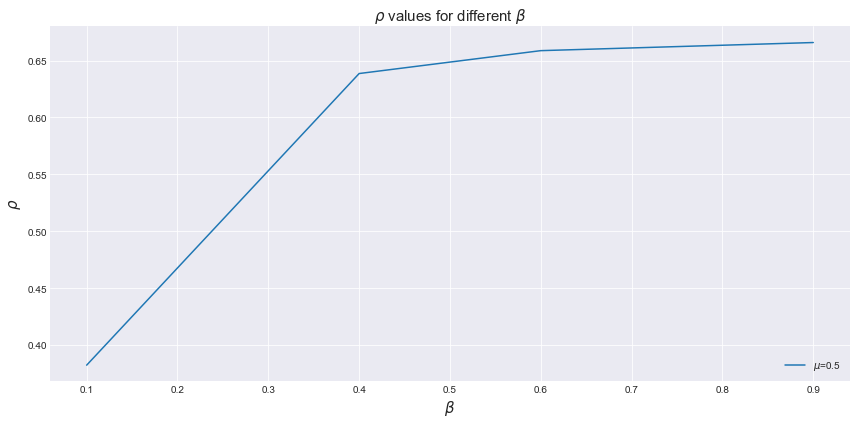

In [14]:
plt.plot(beta_list, avg_over_beta, label=r'$\mu$' + '={}'.format(MU))
plt.title(r'$\rho$' + ' values for different ' + r'$\beta$', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel(r'$\rho$', fontsize=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.style.use('seaborn-darkgrid')

### Full computation
We need now to iterate over mu and beta

In [15]:
mu_list = [0.1, 0.9]
beta_list = [0.1, 0.4, 0.9]
values_per_mu = [] # for each value of mu, we'll have a list 

In [16]:
for mu in mu_list:
    print("Calculate value for mu = {}\n".format(mu))
    values_per_mu.append(iterate_over_beta(g, len_g, mu, beta_list)) 

Calculate value for mu = 0.1

Calculate value for beta = 0.1 (mu = 0.1)
Time required by simulation 1: 0.17950773239135742 seconds
Time required by simulation 2: 0.19892311096191406 seconds
Time required by simulation 3: 0.17298078536987305 seconds
Time required by simulation 4: 0.17787814140319824 seconds
Time required by simulation 5: 0.1652693748474121 seconds
Time required by simulation 6: 0.19708752632141113 seconds
Time required by simulation 7: 0.17453742027282715 seconds
Time required by simulation 8: 0.18541312217712402 seconds
Time required by simulation 9: 0.18788409233093262 seconds
Time required by simulation 10: 0.23970580101013184 seconds
Time required by simulation 11: 0.1983184814453125 seconds
Time required by simulation 12: 0.17809510231018066 seconds
Time required by simulation 13: 0.1914348602294922 seconds
Time required by simulation 14: 0.21002554893493652 seconds
Time required by simulation 15: 0.17467045783996582 seconds
Time required by simulation 16: 0.175835

Time required by simulation 37: 0.09913206100463867 seconds
Time required by simulation 38: 0.10504770278930664 seconds
Time required by simulation 39: 0.1180415153503418 seconds
Time required by simulation 40: 0.1069025993347168 seconds
Time required by simulation 41: 0.10645079612731934 seconds
Time required by simulation 42: 0.10560727119445801 seconds
Time required by simulation 43: 0.10486483573913574 seconds
Time required by simulation 44: 0.1555614471435547 seconds
Time required by simulation 45: 0.15359950065612793 seconds
Time required by simulation 46: 0.1482067108154297 seconds
Time required by simulation 47: 0.10948920249938965 seconds
Time required by simulation 48: 0.10625243186950684 seconds
Time required by simulation 49: 0.12738823890686035 seconds
Time required by simulation 50: 0.13048505783081055 seconds
Time required by simulation 51: 0.10148167610168457 seconds
Time required by simulation 52: 0.12289857864379883 seconds
Time required by simulation 53: 0.1299536228

Time required by simulation 75: 0.10073471069335938 seconds
Time required by simulation 76: 0.11677980422973633 seconds
Time required by simulation 77: 0.1465284824371338 seconds
Time required by simulation 78: 0.15270709991455078 seconds
Time required by simulation 79: 0.13842296600341797 seconds
Time required by simulation 80: 0.11204123497009277 seconds
Time required by simulation 81: 0.12706613540649414 seconds
Time required by simulation 82: 0.11999154090881348 seconds
Time required by simulation 83: 0.13730597496032715 seconds
Time required by simulation 84: 0.13371062278747559 seconds
Time required by simulation 85: 0.12637615203857422 seconds
Time required by simulation 86: 0.1106729507446289 seconds
Time required by simulation 87: 0.11391472816467285 seconds
Time required by simulation 88: 0.12656402587890625 seconds
Time required by simulation 89: 0.11968350410461426 seconds
Time required by simulation 90: 0.1310443878173828 seconds
Time required by simulation 91: 0.152198314

Time required by simulation 10: 0.44410109519958496 seconds
Time required by simulation 11: 0.4384324550628662 seconds
Time required by simulation 12: 0.41637229919433594 seconds
Time required by simulation 13: 0.4543929100036621 seconds
Time required by simulation 14: 0.4561655521392822 seconds
Time required by simulation 15: 0.4461097717285156 seconds
Time required by simulation 16: 0.44173145294189453 seconds
Time required by simulation 17: 0.43817591667175293 seconds
Time required by simulation 18: 0.39154767990112305 seconds
Time required by simulation 19: 0.44760847091674805 seconds
Time required by simulation 20: 0.42847704887390137 seconds
Time required by simulation 21: 0.39130711555480957 seconds
Time required by simulation 22: 0.4639575481414795 seconds
Time required by simulation 23: 0.47611165046691895 seconds
Time required by simulation 24: 0.4828159809112549 seconds
Time required by simulation 25: 0.43591785430908203 seconds
Time required by simulation 26: 0.440424680709

Time required by simulation 48: 0.40403270721435547 seconds
Time required by simulation 49: 0.4258604049682617 seconds
Time required by simulation 50: 0.4889862537384033 seconds
Time required by simulation 51: 0.4760255813598633 seconds
Time required by simulation 52: 0.4225757122039795 seconds
Time required by simulation 53: 0.5561082363128662 seconds
Time required by simulation 54: 0.47209644317626953 seconds
Time required by simulation 55: 0.4427175521850586 seconds
Time required by simulation 56: 0.4337916374206543 seconds
Time required by simulation 57: 0.432589054107666 seconds
Time required by simulation 58: 0.5007269382476807 seconds
Time required by simulation 59: 0.39821767807006836 seconds
Time required by simulation 60: 0.45856261253356934 seconds
Time required by simulation 61: 0.5199501514434814 seconds
Time required by simulation 62: 0.4755725860595703 seconds
Time required by simulation 63: 0.5597062110900879 seconds
Time required by simulation 64: 0.5158004760742188 se

In [17]:
values_per_mu

[array([0.8278652, 0.9049219, 0.9087484]),
 array([0.1756682, 0.481518 , 0.5238186])]

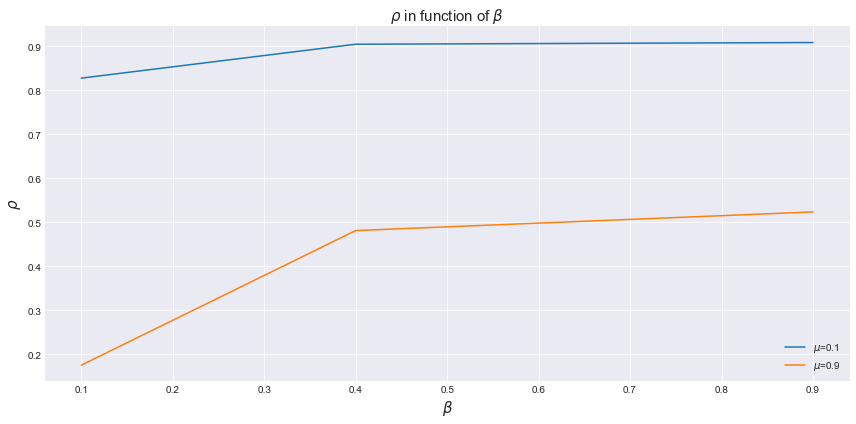

In [18]:
for i in range(len(mu_list)):
    plt.plot(beta_list, values_per_mu[i], label=r'$\mu$' + '={}'.format(mu_list[i]))
    plt.title(r'$\rho$' + ' in function of ' + r'$\beta$', fontsize=15)
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.ylabel(r'$\rho$', fontsize=15)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.style.use('seaborn-darkgrid')

# Example

## Network

In [19]:
len_g = 200
g = ig.Graph.Barabasi(len_g, 5)

### Some network descriptors
We use networkx

In [20]:
import networkx as nx

# read the net as a networkx network
#path = os.path.join("nets", network_f, network_name + '.net')
#G = nx.read_pajek(path)

A = g.get_edgelist()
G = nx.Graph(A)

nnodes = G.number_of_nodes()
print("Number of nodes: {}".format(nnodes))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))


Number of nodes: 200
Number of edges: 985
Min degree: 5
Max degree: 54
Avg degree: 9.85
Clustering: 0.1093
Assortativity: -0.0732
Avg path length: 2.4868
Diameter: 4


### Plot of the network

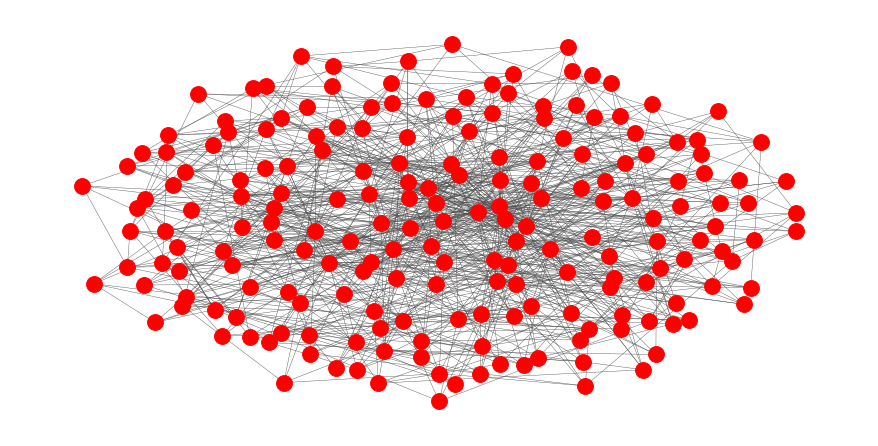

In [21]:
pos = nx.kamada_kawai_layout(G)
# perform the drawing, by using the node coordinates calculated above

# select node size depending on the network size
if nnodes >= 2000:
    node_size = 30
elif nnodes >= 1000 and nnodes < 2000:
    node_size = 50
elif nnodes >= 500 and nnodes  < 1000:
    node_size =  150
else:
    node_size = 250
    
#p_i = os.path.join("images", network_f, network_name)
#if not os.path.exists(p_i):
#    os.makedirs(p_i)
    
nx.draw(G, pos=pos, node_size=node_size, width=0.4, edge_color='0.3', node_color='red')

#plt.savefig(os.path.join(p_i, network_name + '_intro-plot.png')) # to save the plot

### Save network

In [22]:
#g.write_pajek("example")

## Simulation

In [23]:
NREP = 50
P0 = 0.2

### Adjust parameters TMAX and TTRANS by performing a simulation
For these two parameters it would be better to adjust them using a simulation: we plot 
ρ(t) to be sure that, after TTrans time steps, the value of ρ has not a clear tendency to 
increase or decrease, despite the oscillations due to the stochastic nature of the 
simulation process.


In [24]:
# TODO

### Lists

In [25]:
STEP_BETA = 0.02

mu_list = [0.1, 0.5, 0.9]
beta_list = np.arange(0.00, 1.00, STEP_BETA)

In [26]:
len(beta_list) # SHOULD BE AT LEAST 51 VALUES WITH deltaB = 0.02

50

In [27]:
beta_list

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

### Simulation

In [28]:
values_per_mu = []
start_time = time.time()

for mu in mu_list:
    print("Calculate value for mu = {}\n".format(mu))
    values_per_mu.append(iterate_over_beta(g, len_g, mu, beta_list)) 
    
print("Total required time: {} seconds".format(time.time() - start_time))

Calculate value for mu = 0.1

Calculate value for beta = 0.0 (mu = 0.1)
Time required by simulation 1: 0.1695854663848877 seconds
Time required by simulation 2: 0.17912793159484863 seconds
Time required by simulation 3: 0.1338798999786377 seconds
Time required by simulation 4: 0.12994670867919922 seconds
Time required by simulation 5: 0.11638951301574707 seconds
Time required by simulation 6: 0.13593411445617676 seconds
Time required by simulation 7: 0.12612080574035645 seconds
Time required by simulation 8: 0.12700152397155762 seconds
Time required by simulation 9: 0.16699457168579102 seconds
Time required by simulation 10: 0.12354111671447754 seconds
Time required by simulation 11: 0.17726445198059082 seconds
Time required by simulation 12: 0.12306666374206543 seconds
Time required by simulation 13: 0.1414661407470703 seconds
Time required by simulation 14: 0.12021636962890625 seconds
Time required by simulation 15: 0.11977434158325195 seconds
Time required by simulation 16: 0.167075

Time required by simulation 35: 0.062036752700805664 seconds
Time required by simulation 36: 0.06059670448303223 seconds
Time required by simulation 37: 0.06538867950439453 seconds
Time required by simulation 38: 0.0625295639038086 seconds
Time required by simulation 39: 0.06087946891784668 seconds
Time required by simulation 40: 0.05695509910583496 seconds
Time required by simulation 41: 0.061888694763183594 seconds
Time required by simulation 42: 0.05986762046813965 seconds
Time required by simulation 43: 0.06998777389526367 seconds
Time required by simulation 44: 0.08711981773376465 seconds
Time required by simulation 45: 0.07781076431274414 seconds
Time required by simulation 46: 0.06084465980529785 seconds
Time required by simulation 47: 0.0977180004119873 seconds
Time required by simulation 48: 0.08934831619262695 seconds
Time required by simulation 49: 0.060330867767333984 seconds
Time required by simulation 50: 0.05673861503601074 seconds

Time required by 50 simulations: 3.248

Time required by simulation 17: 0.04180192947387695 seconds
Time required by simulation 18: 0.04591107368469238 seconds
Time required by simulation 19: 0.04757952690124512 seconds
Time required by simulation 20: 0.04733419418334961 seconds
Time required by simulation 21: 0.05785202980041504 seconds
Time required by simulation 22: 0.0600738525390625 seconds
Time required by simulation 23: 0.03891324996948242 seconds
Time required by simulation 24: 0.03719639778137207 seconds
Time required by simulation 25: 0.03895235061645508 seconds
Time required by simulation 26: 0.04872584342956543 seconds
Time required by simulation 27: 0.048911333084106445 seconds
Time required by simulation 28: 0.04000973701477051 seconds
Time required by simulation 29: 0.05126214027404785 seconds
Time required by simulation 30: 0.052835702896118164 seconds
Time required by simulation 31: 0.05390310287475586 seconds
Time required by simulation 32: 0.043196678161621094 seconds
Time required by simulation 33: 0.0393

Time required by simulation 3: 0.04279947280883789 seconds
Time required by simulation 4: 0.04240822792053223 seconds
Time required by simulation 5: 0.033333539962768555 seconds
Time required by simulation 6: 0.027704477310180664 seconds
Time required by simulation 7: 0.03794288635253906 seconds
Time required by simulation 8: 0.040853261947631836 seconds
Time required by simulation 9: 0.028886795043945312 seconds
Time required by simulation 10: 0.03193521499633789 seconds
Time required by simulation 11: 0.04100799560546875 seconds
Time required by simulation 12: 0.04961562156677246 seconds
Time required by simulation 13: 0.03740334510803223 seconds
Time required by simulation 14: 0.0296022891998291 seconds
Time required by simulation 15: 0.028783321380615234 seconds
Time required by simulation 16: 0.045667409896850586 seconds
Time required by simulation 17: 0.030985116958618164 seconds
Time required by simulation 18: 0.039679527282714844 seconds
Time required by simulation 19: 0.034788

Time required by simulation 41: 0.02420663833618164 seconds
Time required by simulation 42: 0.025271892547607422 seconds
Time required by simulation 43: 0.023938655853271484 seconds
Time required by simulation 44: 0.029799699783325195 seconds
Time required by simulation 45: 0.03017115592956543 seconds
Time required by simulation 46: 0.029187679290771484 seconds
Time required by simulation 47: 0.0317842960357666 seconds
Time required by simulation 48: 0.03313875198364258 seconds
Time required by simulation 49: 0.029435157775878906 seconds
Time required by simulation 50: 0.02908921241760254 seconds

Time required by 50 simulations: 1.5313198566436768 seconds


Calculate value for beta = 0.22 (mu = 0.1)
Time required by simulation 1: 0.02480292320251465 seconds
Time required by simulation 2: 0.030205726623535156 seconds
Time required by simulation 3: 0.030184268951416016 seconds
Time required by simulation 4: 0.031432151794433594 seconds
Time required by simulation 5: 0.029460668563842773

Time required by simulation 24: 0.04947042465209961 seconds
Time required by simulation 25: 0.042901039123535156 seconds
Time required by simulation 26: 0.03683733940124512 seconds
Time required by simulation 27: 0.03245997428894043 seconds
Time required by simulation 28: 0.030060529708862305 seconds
Time required by simulation 29: 0.029387950897216797 seconds
Time required by simulation 30: 0.03191661834716797 seconds
Time required by simulation 31: 0.03362631797790527 seconds
Time required by simulation 32: 0.0359036922454834 seconds
Time required by simulation 33: 0.037020206451416016 seconds
Time required by simulation 34: 0.02928018569946289 seconds
Time required by simulation 35: 0.02983713150024414 seconds
Time required by simulation 36: 0.029145002365112305 seconds
Time required by simulation 37: 0.033888816833496094 seconds
Time required by simulation 38: 0.028924942016601562 seconds
Time required by simulation 39: 0.027923583984375 seconds
Time required by simulation 40: 0.04

Time required by simulation 6: 0.04528975486755371 seconds
Time required by simulation 7: 0.04341316223144531 seconds
Time required by simulation 8: 0.03899383544921875 seconds
Time required by simulation 9: 0.03394269943237305 seconds
Time required by simulation 10: 0.03414297103881836 seconds
Time required by simulation 11: 0.02883744239807129 seconds
Time required by simulation 12: 0.0249330997467041 seconds
Time required by simulation 13: 0.0271151065826416 seconds
Time required by simulation 14: 0.026291608810424805 seconds
Time required by simulation 15: 0.02691197395324707 seconds
Time required by simulation 16: 0.02859950065612793 seconds
Time required by simulation 17: 0.023106098175048828 seconds
Time required by simulation 18: 0.028802156448364258 seconds
Time required by simulation 19: 0.035895347595214844 seconds
Time required by simulation 20: 0.0313875675201416 seconds
Time required by simulation 21: 0.035655975341796875 seconds
Time required by simulation 22: 0.02826952

Time required by simulation 44: 0.0359492301940918 seconds
Time required by simulation 45: 0.030092954635620117 seconds
Time required by simulation 46: 0.023813724517822266 seconds
Time required by simulation 47: 0.027094125747680664 seconds
Time required by simulation 48: 0.027185916900634766 seconds
Time required by simulation 49: 0.025883913040161133 seconds
Time required by simulation 50: 0.029001712799072266 seconds

Time required by 50 simulations: 1.3825645446777344 seconds


Calculate value for beta = 0.38 (mu = 0.1)
Time required by simulation 1: 0.028002262115478516 seconds
Time required by simulation 2: 0.031923770904541016 seconds
Time required by simulation 3: 0.02441239356994629 seconds
Time required by simulation 4: 0.02935647964477539 seconds
Time required by simulation 5: 0.027223587036132812 seconds
Time required by simulation 6: 0.02360844612121582 seconds
Time required by simulation 7: 0.02477884292602539 seconds
Time required by simulation 8: 0.031176090240478516 s

Time required by simulation 31: 0.024259090423583984 seconds
Time required by simulation 32: 0.027530670166015625 seconds
Time required by simulation 33: 0.025546550750732422 seconds
Time required by simulation 34: 0.028478145599365234 seconds
Time required by simulation 35: 0.03042745590209961 seconds
Time required by simulation 36: 0.026477336883544922 seconds
Time required by simulation 37: 0.05111384391784668 seconds
Time required by simulation 38: 0.06878852844238281 seconds
Time required by simulation 39: 0.035106658935546875 seconds
Time required by simulation 40: 0.04158163070678711 seconds
Time required by simulation 41: 0.0407412052154541 seconds
Time required by simulation 42: 0.029274702072143555 seconds
Time required by simulation 43: 0.029181241989135742 seconds
Time required by simulation 44: 0.025212526321411133 seconds
Time required by simulation 45: 0.023148298263549805 seconds
Time required by simulation 46: 0.02633380889892578 seconds
Time required by simulation 47:

Time required by simulation 15: 0.0249326229095459 seconds
Time required by simulation 16: 0.031065940856933594 seconds
Time required by simulation 17: 0.03335833549499512 seconds
Time required by simulation 18: 0.03396105766296387 seconds
Time required by simulation 19: 0.04493260383605957 seconds
Time required by simulation 20: 0.023746728897094727 seconds
Time required by simulation 21: 0.03929424285888672 seconds
Time required by simulation 22: 0.03892040252685547 seconds
Time required by simulation 23: 0.033148765563964844 seconds
Time required by simulation 24: 0.03298592567443848 seconds
Time required by simulation 25: 0.03887128829956055 seconds
Time required by simulation 26: 0.037462472915649414 seconds
Time required by simulation 27: 0.03906130790710449 seconds
Time required by simulation 28: 0.03437089920043945 seconds
Time required by simulation 29: 0.03305363655090332 seconds
Time required by simulation 30: 0.026934146881103516 seconds
Time required by simulation 31: 0.02

Time required by simulation 4: 0.018442869186401367 seconds
Time required by simulation 5: 0.03045368194580078 seconds
Time required by simulation 6: 0.03056645393371582 seconds
Time required by simulation 7: 0.027109146118164062 seconds
Time required by simulation 8: 0.03190898895263672 seconds
Time required by simulation 9: 0.028296947479248047 seconds
Time required by simulation 10: 0.02196502685546875 seconds
Time required by simulation 11: 0.026575565338134766 seconds
Time required by simulation 12: 0.03099679946899414 seconds
Time required by simulation 13: 0.03191494941711426 seconds
Time required by simulation 14: 0.03487133979797363 seconds
Time required by simulation 15: 0.0320124626159668 seconds
Time required by simulation 16: 0.028861045837402344 seconds
Time required by simulation 17: 0.02210092544555664 seconds
Time required by simulation 18: 0.0228574275970459 seconds
Time required by simulation 19: 0.03128194808959961 seconds
Time required by simulation 20: 0.025975704

Time required by simulation 40: 0.029739856719970703 seconds
Time required by simulation 41: 0.02792501449584961 seconds
Time required by simulation 42: 0.022025108337402344 seconds
Time required by simulation 43: 0.019948244094848633 seconds
Time required by simulation 44: 0.018126726150512695 seconds
Time required by simulation 45: 0.020169973373413086 seconds
Time required by simulation 46: 0.018328189849853516 seconds
Time required by simulation 47: 0.017354726791381836 seconds
Time required by simulation 48: 0.019092321395874023 seconds
Time required by simulation 49: 0.019654273986816406 seconds
Time required by simulation 50: 0.024349689483642578 seconds

Time required by 50 simulations: 1.1327345371246338 seconds


Calculate value for beta = 0.6 (mu = 0.1)
Time required by simulation 1: 0.02544546127319336 seconds
Time required by simulation 2: 0.023528337478637695 seconds
Time required by simulation 3: 0.023296356201171875 seconds
Time required by simulation 4: 0.0327246189117

Time required by simulation 21: 0.029919862747192383 seconds
Time required by simulation 22: 0.023936033248901367 seconds
Time required by simulation 23: 0.025931596755981445 seconds
Time required by simulation 24: 0.025928020477294922 seconds
Time required by simulation 25: 0.02593231201171875 seconds
Time required by simulation 26: 0.02393364906311035 seconds
Time required by simulation 27: 0.023056745529174805 seconds
Time required by simulation 28: 0.017833948135375977 seconds
Time required by simulation 29: 0.02892303466796875 seconds
Time required by simulation 30: 0.022478342056274414 seconds
Time required by simulation 31: 0.0184173583984375 seconds
Time required by simulation 32: 0.025931119918823242 seconds
Time required by simulation 33: 0.029911518096923828 seconds
Time required by simulation 34: 0.025957345962524414 seconds
Time required by simulation 35: 0.028895139694213867 seconds
Time required by simulation 36: 0.027925491333007812 seconds
Time required by simulation 3

Time required by simulation 13: 0.02205801010131836 seconds
Time required by simulation 14: 0.03091907501220703 seconds
Time required by simulation 15: 0.029906749725341797 seconds
Time required by simulation 16: 0.029973506927490234 seconds
Time required by simulation 17: 0.03890371322631836 seconds
Time required by simulation 18: 0.024867773056030273 seconds
Time required by simulation 19: 0.023491382598876953 seconds
Time required by simulation 20: 0.027354001998901367 seconds
Time required by simulation 21: 0.024931669235229492 seconds
Time required by simulation 22: 0.024921417236328125 seconds
Time required by simulation 23: 0.02792525291442871 seconds
Time required by simulation 24: 0.023936033248901367 seconds
Time required by simulation 25: 0.024933576583862305 seconds
Time required by simulation 26: 0.021952152252197266 seconds
Time required by simulation 27: 0.024951457977294922 seconds
Time required by simulation 28: 0.02490687370300293 seconds
Time required by simulation 2

Time required by simulation 3: 0.017952919006347656 seconds
Time required by simulation 4: 0.017951488494873047 seconds
Time required by simulation 5: 0.02094411849975586 seconds
Time required by simulation 6: 0.02866673469543457 seconds
Time required by simulation 7: 0.03040027618408203 seconds
Time required by simulation 8: 0.02742910385131836 seconds
Time required by simulation 9: 0.024477005004882812 seconds
Time required by simulation 10: 0.019003868103027344 seconds
Time required by simulation 11: 0.019974708557128906 seconds
Time required by simulation 12: 0.022962093353271484 seconds
Time required by simulation 13: 0.02163243293762207 seconds
Time required by simulation 14: 0.019517183303833008 seconds
Time required by simulation 15: 0.01992344856262207 seconds
Time required by simulation 16: 0.02351522445678711 seconds
Time required by simulation 17: 0.019868850708007812 seconds
Time required by simulation 18: 0.021209239959716797 seconds
Time required by simulation 19: 0.0215

Time required by simulation 43: 0.01796579360961914 seconds
Time required by simulation 44: 0.016925334930419922 seconds
Time required by simulation 45: 0.019576072692871094 seconds
Time required by simulation 46: 0.023931503295898438 seconds
Time required by simulation 47: 0.021022796630859375 seconds
Time required by simulation 48: 0.0240476131439209 seconds
Time required by simulation 49: 0.024482250213623047 seconds
Time required by simulation 50: 0.025368690490722656 seconds

Time required by 50 simulations: 1.1226749420166016 seconds


Calculate value for beta = 0.8200000000000001 (mu = 0.1)
Time required by simulation 1: 0.022616147994995117 seconds
Time required by simulation 2: 0.02314138412475586 seconds
Time required by simulation 3: 0.03392744064331055 seconds
Time required by simulation 4: 0.03130316734313965 seconds
Time required by simulation 5: 0.032009124755859375 seconds
Time required by simulation 6: 0.028951406478881836 seconds
Time required by simulation 7: 0.02068

Time required by simulation 27: 0.016955852508544922 seconds
Time required by simulation 28: 0.018949508666992188 seconds
Time required by simulation 29: 0.01731085777282715 seconds
Time required by simulation 30: 0.018604278564453125 seconds
Time required by simulation 31: 0.020975589752197266 seconds
Time required by simulation 32: 0.019678354263305664 seconds
Time required by simulation 33: 0.016979455947875977 seconds
Time required by simulation 34: 0.019504785537719727 seconds
Time required by simulation 35: 0.018505573272705078 seconds
Time required by simulation 36: 0.018018245697021484 seconds
Time required by simulation 37: 0.022190093994140625 seconds
Time required by simulation 38: 0.02294158935546875 seconds
Time required by simulation 39: 0.021197080612182617 seconds
Time required by simulation 40: 0.01706671714782715 seconds
Time required by simulation 41: 0.019932270050048828 seconds
Time required by simulation 42: 0.023098230361938477 seconds
Time required by simulation

Time required by simulation 18: 0.019538402557373047 seconds
Time required by simulation 19: 0.021004438400268555 seconds
Time required by simulation 20: 0.01893138885498047 seconds
Time required by simulation 21: 0.020928621292114258 seconds
Time required by simulation 22: 0.02208566665649414 seconds
Time required by simulation 23: 0.018472671508789062 seconds
Time required by simulation 24: 0.017940998077392578 seconds
Time required by simulation 25: 0.01595473289489746 seconds
Time required by simulation 26: 0.015917301177978516 seconds
Time required by simulation 27: 0.01702713966369629 seconds
Time required by simulation 28: 0.018210887908935547 seconds
Time required by simulation 29: 0.018976926803588867 seconds
Time required by simulation 30: 0.017513751983642578 seconds
Time required by simulation 31: 0.017950773239135742 seconds
Time required by simulation 32: 0.019933700561523438 seconds
Time required by simulation 33: 0.024359464645385742 seconds
Time required by simulation 

Time required by simulation 1: 0.019940853118896484 seconds
Time required by simulation 2: 0.019228458404541016 seconds
Time required by simulation 3: 0.021825313568115234 seconds
Time required by simulation 4: 0.029316186904907227 seconds
Time required by simulation 5: 0.03205156326293945 seconds
Time required by simulation 6: 0.020886659622192383 seconds
Time required by simulation 7: 0.020956039428710938 seconds
Time required by simulation 8: 0.018967390060424805 seconds
Time required by simulation 9: 0.01893138885498047 seconds
Time required by simulation 10: 0.022945404052734375 seconds
Time required by simulation 11: 0.021945714950561523 seconds
Time required by simulation 12: 0.022552967071533203 seconds
Time required by simulation 13: 0.021950721740722656 seconds
Time required by simulation 14: 0.021939754486083984 seconds
Time required by simulation 15: 0.02350139617919922 seconds
Time required by simulation 16: 0.01955437660217285 seconds
Time required by simulation 17: 0.018

Time required by simulation 34: 0.20056438446044922 seconds
Time required by simulation 35: 0.2218618392944336 seconds
Time required by simulation 36: 0.19896602630615234 seconds
Time required by simulation 37: 0.20005154609680176 seconds
Time required by simulation 38: 0.2479381561279297 seconds
Time required by simulation 39: 0.25079941749572754 seconds
Time required by simulation 40: 0.1721644401550293 seconds
Time required by simulation 41: 0.17135119438171387 seconds
Time required by simulation 42: 0.18054604530334473 seconds
Time required by simulation 43: 0.2330458164215088 seconds
Time required by simulation 44: 0.20727086067199707 seconds
Time required by simulation 45: 0.15164518356323242 seconds
Time required by simulation 46: 0.1540074348449707 seconds
Time required by simulation 47: 0.17651724815368652 seconds
Time required by simulation 48: 0.18276309967041016 seconds
Time required by simulation 49: 0.19700932502746582 seconds
Time required by simulation 50: 0.20131182670

Time required by simulation 18: 0.1478731632232666 seconds
Time required by simulation 19: 0.1210167407989502 seconds
Time required by simulation 20: 0.11817717552185059 seconds
Time required by simulation 21: 0.13800549507141113 seconds
Time required by simulation 22: 0.1271500587463379 seconds
Time required by simulation 23: 0.11242222785949707 seconds
Time required by simulation 24: 0.15775132179260254 seconds
Time required by simulation 25: 0.12095499038696289 seconds
Time required by simulation 26: 0.1213984489440918 seconds
Time required by simulation 27: 0.13014459609985352 seconds
Time required by simulation 28: 0.14658689498901367 seconds
Time required by simulation 29: 0.12217378616333008 seconds
Time required by simulation 30: 0.11878180503845215 seconds
Time required by simulation 31: 0.12244844436645508 seconds
Time required by simulation 32: 0.13138508796691895 seconds
Time required by simulation 33: 0.12813663482666016 seconds
Time required by simulation 34: 0.1264035701

Time required by simulation 4: 0.0884256362915039 seconds
Time required by simulation 5: 0.11038064956665039 seconds
Time required by simulation 6: 0.0781710147857666 seconds
Time required by simulation 7: 0.0720970630645752 seconds
Time required by simulation 8: 0.08624982833862305 seconds
Time required by simulation 9: 0.08924984931945801 seconds
Time required by simulation 10: 0.0908975601196289 seconds
Time required by simulation 11: 0.07500839233398438 seconds
Time required by simulation 12: 0.07731151580810547 seconds
Time required by simulation 13: 0.08322811126708984 seconds
Time required by simulation 14: 0.07845258712768555 seconds
Time required by simulation 15: 0.06899380683898926 seconds
Time required by simulation 16: 0.0694272518157959 seconds
Time required by simulation 17: 0.08930039405822754 seconds
Time required by simulation 18: 0.09415960311889648 seconds
Time required by simulation 19: 0.09535980224609375 seconds
Time required by simulation 20: 0.09383487701416016

Time required by simulation 38: 0.06760001182556152 seconds
Time required by simulation 39: 0.07438945770263672 seconds
Time required by simulation 40: 0.06634187698364258 seconds
Time required by simulation 41: 0.06970000267028809 seconds
Time required by simulation 42: 0.06668734550476074 seconds
Time required by simulation 43: 0.06707310676574707 seconds
Time required by simulation 44: 0.07984757423400879 seconds
Time required by simulation 45: 0.0722653865814209 seconds
Time required by simulation 46: 0.0749049186706543 seconds
Time required by simulation 47: 0.07868576049804688 seconds
Time required by simulation 48: 0.06930232048034668 seconds
Time required by simulation 49: 0.0666806697845459 seconds
Time required by simulation 50: 0.07119202613830566 seconds

Time required by 50 simulations: 3.691606044769287 seconds


Calculate value for beta = 0.2 (mu = 0.5)
Time required by simulation 1: 0.06957840919494629 seconds
Time required by simulation 2: 0.06989288330078125 seconds
T

Time required by simulation 21: 0.06828951835632324 seconds
Time required by simulation 22: 0.06650543212890625 seconds
Time required by simulation 23: 0.06880640983581543 seconds
Time required by simulation 24: 0.0856485366821289 seconds
Time required by simulation 25: 0.08782720565795898 seconds
Time required by simulation 26: 0.07011699676513672 seconds
Time required by simulation 27: 0.07185816764831543 seconds
Time required by simulation 28: 0.06891107559204102 seconds
Time required by simulation 29: 0.06812071800231934 seconds
Time required by simulation 30: 0.0713798999786377 seconds
Time required by simulation 31: 0.06764960289001465 seconds
Time required by simulation 32: 0.0623321533203125 seconds
Time required by simulation 33: 0.0766141414642334 seconds
Time required by simulation 34: 0.07877635955810547 seconds
Time required by simulation 35: 0.0632181167602539 seconds
Time required by simulation 36: 0.07692646980285645 seconds
Time required by simulation 37: 0.08228588104

Time required by simulation 4: 0.11979889869689941 seconds
Time required by simulation 5: 0.12193536758422852 seconds
Time required by simulation 6: 0.11603951454162598 seconds
Time required by simulation 7: 0.10355424880981445 seconds
Time required by simulation 8: 0.10792040824890137 seconds
Time required by simulation 9: 0.1106252670288086 seconds
Time required by simulation 10: 0.10904455184936523 seconds
Time required by simulation 11: 0.09132099151611328 seconds
Time required by simulation 12: 0.1411597728729248 seconds
Time required by simulation 13: 0.09844684600830078 seconds
Time required by simulation 14: 0.09482693672180176 seconds
Time required by simulation 15: 0.09304356575012207 seconds
Time required by simulation 16: 0.09960150718688965 seconds
Time required by simulation 17: 0.07884049415588379 seconds
Time required by simulation 18: 0.10169601440429688 seconds
Time required by simulation 19: 0.08621835708618164 seconds
Time required by simulation 20: 0.09458017349243

Time required by simulation 39: 0.08632016181945801 seconds
Time required by simulation 40: 0.10883760452270508 seconds
Time required by simulation 41: 0.0837562084197998 seconds
Time required by simulation 42: 0.09866046905517578 seconds
Time required by simulation 43: 0.07139468193054199 seconds
Time required by simulation 44: 0.08432841300964355 seconds
Time required by simulation 45: 0.0869741439819336 seconds
Time required by simulation 46: 0.06903195381164551 seconds
Time required by simulation 47: 0.08504915237426758 seconds
Time required by simulation 48: 0.08132219314575195 seconds
Time required by simulation 49: 0.0675497055053711 seconds
Time required by simulation 50: 0.09193921089172363 seconds

Time required by 50 simulations: 4.312967300415039 seconds


Calculate value for beta = 0.36 (mu = 0.5)
Time required by simulation 1: 0.10406613349914551 seconds
Time required by simulation 2: 0.09227228164672852 seconds
Time required by simulation 3: 0.06551718711853027 seconds
T

Time required by simulation 25: 0.07972526550292969 seconds
Time required by simulation 26: 0.07052087783813477 seconds
Time required by simulation 27: 0.07414460182189941 seconds
Time required by simulation 28: 0.07728457450866699 seconds
Time required by simulation 29: 0.07907438278198242 seconds
Time required by simulation 30: 0.07214117050170898 seconds
Time required by simulation 31: 0.07436251640319824 seconds
Time required by simulation 32: 0.07393121719360352 seconds
Time required by simulation 33: 0.06929326057434082 seconds
Time required by simulation 34: 0.07010459899902344 seconds
Time required by simulation 35: 0.08209419250488281 seconds
Time required by simulation 36: 0.06949043273925781 seconds
Time required by simulation 37: 0.079437255859375 seconds
Time required by simulation 38: 0.07085704803466797 seconds
Time required by simulation 39: 0.07578444480895996 seconds
Time required by simulation 40: 0.08834195137023926 seconds
Time required by simulation 41: 0.08903574

Time required by simulation 10: 0.05674266815185547 seconds
Time required by simulation 11: 0.05398297309875488 seconds
Time required by simulation 12: 0.05967116355895996 seconds
Time required by simulation 13: 0.05790233612060547 seconds
Time required by simulation 14: 0.056097984313964844 seconds
Time required by simulation 15: 0.052896976470947266 seconds
Time required by simulation 16: 0.056526899337768555 seconds
Time required by simulation 17: 0.0647892951965332 seconds
Time required by simulation 18: 0.06835222244262695 seconds
Time required by simulation 19: 0.0770261287689209 seconds
Time required by simulation 20: 0.05798792839050293 seconds
Time required by simulation 21: 0.04372286796569824 seconds
Time required by simulation 22: 0.05344128608703613 seconds
Time required by simulation 23: 0.0615842342376709 seconds
Time required by simulation 24: 0.05541825294494629 seconds
Time required by simulation 25: 0.05229544639587402 seconds
Time required by simulation 26: 0.059770

Time required by simulation 48: 0.05997490882873535 seconds
Time required by simulation 49: 0.0552363395690918 seconds
Time required by simulation 50: 0.056844234466552734 seconds

Time required by 50 simulations: 2.8870620727539062 seconds


Calculate value for beta = 0.52 (mu = 0.5)
Time required by simulation 1: 0.05628085136413574 seconds
Time required by simulation 2: 0.05886054039001465 seconds
Time required by simulation 3: 0.05684804916381836 seconds
Time required by simulation 4: 0.054852962493896484 seconds
Time required by simulation 5: 0.053376197814941406 seconds
Time required by simulation 6: 0.05659961700439453 seconds
Time required by simulation 7: 0.05485272407531738 seconds
Time required by simulation 8: 0.052397727966308594 seconds
Time required by simulation 9: 0.05363130569458008 seconds
Time required by simulation 10: 0.05315351486206055 seconds
Time required by simulation 11: 0.053723812103271484 seconds
Time required by simulation 12: 0.050623178482055664 second

Time required by simulation 34: 0.061568498611450195 seconds
Time required by simulation 35: 0.0592961311340332 seconds
Time required by simulation 36: 0.06668496131896973 seconds
Time required by simulation 37: 0.06607842445373535 seconds
Time required by simulation 38: 0.06165122985839844 seconds
Time required by simulation 39: 0.06361079216003418 seconds
Time required by simulation 40: 0.0480344295501709 seconds
Time required by simulation 41: 0.04974794387817383 seconds
Time required by simulation 42: 0.05094766616821289 seconds
Time required by simulation 43: 0.05523538589477539 seconds
Time required by simulation 44: 0.07309985160827637 seconds
Time required by simulation 45: 0.050650835037231445 seconds
Time required by simulation 46: 0.05149126052856445 seconds
Time required by simulation 47: 0.049582719802856445 seconds
Time required by simulation 48: 0.053836822509765625 seconds
Time required by simulation 49: 0.04703164100646973 seconds
Time required by simulation 50: 0.0489

Time required by simulation 16: 0.05845499038696289 seconds
Time required by simulation 17: 0.046567678451538086 seconds
Time required by simulation 18: 0.056882381439208984 seconds
Time required by simulation 19: 0.05942654609680176 seconds
Time required by simulation 20: 0.05873465538024902 seconds
Time required by simulation 21: 0.07235550880432129 seconds
Time required by simulation 22: 0.07661581039428711 seconds
Time required by simulation 23: 0.0580601692199707 seconds
Time required by simulation 24: 0.05395960807800293 seconds
Time required by simulation 25: 0.06000208854675293 seconds
Time required by simulation 26: 0.0623931884765625 seconds
Time required by simulation 27: 0.0578160285949707 seconds
Time required by simulation 28: 0.054712533950805664 seconds
Time required by simulation 29: 0.06249856948852539 seconds
Time required by simulation 30: 0.056391000747680664 seconds
Time required by simulation 31: 0.05072426795959473 seconds
Time required by simulation 32: 0.05876

Time required by simulation 3: 0.05317282676696777 seconds
Time required by simulation 4: 0.05447506904602051 seconds
Time required by simulation 5: 0.062652587890625 seconds
Time required by simulation 6: 0.052849769592285156 seconds
Time required by simulation 7: 0.04886937141418457 seconds
Time required by simulation 8: 0.05633735656738281 seconds
Time required by simulation 9: 0.05587315559387207 seconds
Time required by simulation 10: 0.05278611183166504 seconds
Time required by simulation 11: 0.05540108680725098 seconds
Time required by simulation 12: 0.057135820388793945 seconds
Time required by simulation 13: 0.08778738975524902 seconds
Time required by simulation 14: 0.05824637413024902 seconds
Time required by simulation 15: 0.05774521827697754 seconds
Time required by simulation 16: 0.05509042739868164 seconds
Time required by simulation 17: 0.05581927299499512 seconds
Time required by simulation 18: 0.052872419357299805 seconds
Time required by simulation 19: 0.054986000061

Time required by simulation 37: 0.18027138710021973 seconds
Time required by simulation 38: 0.13753628730773926 seconds
Time required by simulation 39: 0.1603846549987793 seconds
Time required by simulation 40: 0.10064220428466797 seconds
Time required by simulation 41: 0.08194684982299805 seconds
Time required by simulation 42: 0.08697342872619629 seconds
Time required by simulation 43: 0.078887939453125 seconds
Time required by simulation 44: 0.07376933097839355 seconds
Time required by simulation 45: 0.0729682445526123 seconds
Time required by simulation 46: 0.0673055648803711 seconds
Time required by simulation 47: 0.06387591361999512 seconds
Time required by simulation 48: 0.06482648849487305 seconds
Time required by simulation 49: 0.07340455055236816 seconds
Time required by simulation 50: 0.07720756530761719 seconds

Time required by 50 simulations: 3.478144884109497 seconds


Calculate value for beta = 0.74 (mu = 0.5)
Time required by simulation 1: 0.07093286514282227 seconds
T

Time required by simulation 22: 0.0825355052947998 seconds
Time required by simulation 23: 0.07691144943237305 seconds
Time required by simulation 24: 0.08643293380737305 seconds
Time required by simulation 25: 0.0789637565612793 seconds
Time required by simulation 26: 0.08191084861755371 seconds
Time required by simulation 27: 0.0987694263458252 seconds
Time required by simulation 28: 0.07123064994812012 seconds
Time required by simulation 29: 0.09305953979492188 seconds
Time required by simulation 30: 0.08176112174987793 seconds
Time required by simulation 31: 0.09696674346923828 seconds
Time required by simulation 32: 0.0967411994934082 seconds
Time required by simulation 33: 0.08664560317993164 seconds
Time required by simulation 34: 0.08192920684814453 seconds
Time required by simulation 35: 0.13140249252319336 seconds
Time required by simulation 36: 0.07762789726257324 seconds
Time required by simulation 37: 0.07637834548950195 seconds
Time required by simulation 38: 0.0844080448

Time required by simulation 9: 0.07170653343200684 seconds
Time required by simulation 10: 0.08857488632202148 seconds
Time required by simulation 11: 0.06916260719299316 seconds
Time required by simulation 12: 0.06588435173034668 seconds
Time required by simulation 13: 0.07720041275024414 seconds
Time required by simulation 14: 0.06183433532714844 seconds
Time required by simulation 15: 0.0733957290649414 seconds
Time required by simulation 16: 0.08857560157775879 seconds
Time required by simulation 17: 0.08298468589782715 seconds
Time required by simulation 18: 0.09245729446411133 seconds
Time required by simulation 19: 0.0718386173248291 seconds
Time required by simulation 20: 0.11961197853088379 seconds
Time required by simulation 21: 0.11861300468444824 seconds
Time required by simulation 22: 0.08984494209289551 seconds
Time required by simulation 23: 0.08097505569458008 seconds
Time required by simulation 24: 0.09267139434814453 seconds
Time required by simulation 25: 0.089289903

Time required by simulation 44: 0.08699584007263184 seconds
Time required by simulation 45: 0.08065319061279297 seconds
Time required by simulation 46: 0.07318115234375 seconds
Time required by simulation 47: 0.0608820915222168 seconds
Time required by simulation 48: 0.0648343563079834 seconds
Time required by simulation 49: 0.10342264175415039 seconds
Time required by simulation 50: 0.07988739013671875 seconds

Time required by 50 simulations: 4.229957580566406 seconds


Calculate value for beta = 0.9 (mu = 0.5)
Time required by simulation 1: 0.08175277709960938 seconds
Time required by simulation 2: 0.07904958724975586 seconds
Time required by simulation 3: 0.07314705848693848 seconds
Time required by simulation 4: 0.07380461692810059 seconds
Time required by simulation 5: 0.07206296920776367 seconds
Time required by simulation 6: 0.07413291931152344 seconds
Time required by simulation 7: 0.06502056121826172 seconds
Time required by simulation 8: 0.07007145881652832 seconds
Time requ

Time required by simulation 26: 0.09724569320678711 seconds
Time required by simulation 27: 0.07932782173156738 seconds
Time required by simulation 28: 0.06006455421447754 seconds
Time required by simulation 29: 0.06008267402648926 seconds
Time required by simulation 30: 0.06489825248718262 seconds
Time required by simulation 31: 0.06316232681274414 seconds
Time required by simulation 32: 0.057465314865112305 seconds
Time required by simulation 33: 0.07052159309387207 seconds
Time required by simulation 34: 0.06128835678100586 seconds
Time required by simulation 35: 0.05383801460266113 seconds
Time required by simulation 36: 0.05075430870056152 seconds
Time required by simulation 37: 0.05693387985229492 seconds
Time required by simulation 38: 0.05141854286193848 seconds
Time required by simulation 39: 0.05954337120056152 seconds
Time required by simulation 40: 0.05360293388366699 seconds
Time required by simulation 41: 0.04970979690551758 seconds
Time required by simulation 42: 0.05285

Time required by simulation 10: 0.1575329303741455 seconds
Time required by simulation 11: 0.13115930557250977 seconds
Time required by simulation 12: 0.16913604736328125 seconds
Time required by simulation 13: 0.24655985832214355 seconds
Time required by simulation 14: 0.23831915855407715 seconds
Time required by simulation 15: 0.2557036876678467 seconds
Time required by simulation 16: 0.20991301536560059 seconds
Time required by simulation 17: 0.24474668502807617 seconds
Time required by simulation 18: 0.19250202178955078 seconds
Time required by simulation 19: 0.171586275100708 seconds
Time required by simulation 20: 0.15669775009155273 seconds
Time required by simulation 21: 0.21914052963256836 seconds
Time required by simulation 22: 0.20349717140197754 seconds
Time required by simulation 23: 0.27602291107177734 seconds
Time required by simulation 24: 0.23080897331237793 seconds
Time required by simulation 25: 0.18169569969177246 seconds
Time required by simulation 26: 0.2045955657

Time required by simulation 44: 0.23532819747924805 seconds
Time required by simulation 45: 0.23599743843078613 seconds
Time required by simulation 46: 0.22297239303588867 seconds
Time required by simulation 47: 0.19430112838745117 seconds
Time required by simulation 48: 0.17728257179260254 seconds
Time required by simulation 49: 0.1804027557373047 seconds
Time required by simulation 50: 0.2098534107208252 seconds

Time required by 50 simulations: 10.13766884803772 seconds


Calculate value for beta = 0.06 (mu = 0.9)
Time required by simulation 1: 0.23804831504821777 seconds
Time required by simulation 2: 0.22785401344299316 seconds
Time required by simulation 3: 0.24035882949829102 seconds
Time required by simulation 4: 0.22699403762817383 seconds
Time required by simulation 5: 0.18151140213012695 seconds
Time required by simulation 6: 0.21611595153808594 seconds
Time required by simulation 7: 0.19286203384399414 seconds
Time required by simulation 8: 0.20876121520996094 seconds
Time 

Time required by simulation 29: 0.11659550666809082 seconds
Time required by simulation 30: 0.12685728073120117 seconds
Time required by simulation 31: 0.1046302318572998 seconds
Time required by simulation 32: 0.11509132385253906 seconds
Time required by simulation 33: 0.14514422416687012 seconds
Time required by simulation 34: 0.12984347343444824 seconds
Time required by simulation 35: 0.1252748966217041 seconds
Time required by simulation 36: 0.11292862892150879 seconds
Time required by simulation 37: 0.11373162269592285 seconds
Time required by simulation 38: 0.1331920623779297 seconds
Time required by simulation 39: 0.0993499755859375 seconds
Time required by simulation 40: 0.10754871368408203 seconds
Time required by simulation 41: 0.11028265953063965 seconds
Time required by simulation 42: 0.11074447631835938 seconds
Time required by simulation 43: 0.11323237419128418 seconds
Time required by simulation 44: 0.12180542945861816 seconds
Time required by simulation 45: 0.1203556060

Time required by simulation 14: 0.1071779727935791 seconds
Time required by simulation 15: 0.13681769371032715 seconds
Time required by simulation 16: 0.11068511009216309 seconds
Time required by simulation 17: 0.11000967025756836 seconds
Time required by simulation 18: 0.10121846199035645 seconds
Time required by simulation 19: 0.09278535842895508 seconds
Time required by simulation 20: 0.09158515930175781 seconds
Time required by simulation 21: 0.102813720703125 seconds
Time required by simulation 22: 0.11319756507873535 seconds
Time required by simulation 23: 0.1223917007446289 seconds
Time required by simulation 24: 0.09048748016357422 seconds
Time required by simulation 25: 0.12122774124145508 seconds
Time required by simulation 26: 0.18568944931030273 seconds
Time required by simulation 27: 0.0886075496673584 seconds
Time required by simulation 28: 0.1013939380645752 seconds
Time required by simulation 29: 0.09301567077636719 seconds
Time required by simulation 30: 0.119362592697

Time required by simulation 49: 0.09635519981384277 seconds
Time required by simulation 50: 0.09574317932128906 seconds

Time required by 50 simulations: 5.443880558013916 seconds


Calculate value for beta = 0.22 (mu = 0.9)
Time required by simulation 1: 0.15015721321105957 seconds
Time required by simulation 2: 0.11513686180114746 seconds
Time required by simulation 3: 0.09655976295471191 seconds
Time required by simulation 4: 0.08914875984191895 seconds
Time required by simulation 5: 0.08609747886657715 seconds
Time required by simulation 6: 0.09298443794250488 seconds
Time required by simulation 7: 0.13979840278625488 seconds
Time required by simulation 8: 0.0885775089263916 seconds
Time required by simulation 9: 0.09274101257324219 seconds
Time required by simulation 10: 0.0986931324005127 seconds
Time required by simulation 11: 0.09740471839904785 seconds
Time required by simulation 12: 0.11261510848999023 seconds
Time required by simulation 13: 0.09598302841186523 seconds
Time r

Time required by simulation 35: 0.10227012634277344 seconds
Time required by simulation 36: 0.07989883422851562 seconds
Time required by simulation 37: 0.10116887092590332 seconds
Time required by simulation 38: 0.0986318588256836 seconds
Time required by simulation 39: 0.0938253402709961 seconds
Time required by simulation 40: 0.11184859275817871 seconds
Time required by simulation 41: 0.1102151870727539 seconds
Time required by simulation 42: 0.10831308364868164 seconds
Time required by simulation 43: 0.11552977561950684 seconds
Time required by simulation 44: 0.1283092498779297 seconds
Time required by simulation 45: 0.09416580200195312 seconds
Time required by simulation 46: 0.09548139572143555 seconds
Time required by simulation 47: 0.09884333610534668 seconds
Time required by simulation 48: 0.09682631492614746 seconds
Time required by simulation 49: 0.10325288772583008 seconds
Time required by simulation 50: 0.10542678833007812 seconds

Time required by 50 simulations: 4.92613148

Time required by simulation 21: 0.07756519317626953 seconds
Time required by simulation 22: 0.0793449878692627 seconds
Time required by simulation 23: 0.08457803726196289 seconds
Time required by simulation 24: 0.07731389999389648 seconds
Time required by simulation 25: 0.07404422760009766 seconds
Time required by simulation 26: 0.08724117279052734 seconds
Time required by simulation 27: 0.0801689624786377 seconds
Time required by simulation 28: 0.09292793273925781 seconds
Time required by simulation 29: 0.07995128631591797 seconds
Time required by simulation 30: 0.08690738677978516 seconds
Time required by simulation 31: 0.07831835746765137 seconds
Time required by simulation 32: 0.07274937629699707 seconds
Time required by simulation 33: 0.07813572883605957 seconds
Time required by simulation 34: 0.07510161399841309 seconds
Time required by simulation 35: 0.08066534996032715 seconds
Time required by simulation 36: 0.0820310115814209 seconds
Time required by simulation 37: 0.079132080

Time required by simulation 4: 0.07749795913696289 seconds
Time required by simulation 5: 0.07596349716186523 seconds
Time required by simulation 6: 0.07987785339355469 seconds
Time required by simulation 7: 0.07644248008728027 seconds
Time required by simulation 8: 0.07613134384155273 seconds
Time required by simulation 9: 0.07079219818115234 seconds
Time required by simulation 10: 0.0751340389251709 seconds
Time required by simulation 11: 0.0811457633972168 seconds
Time required by simulation 12: 0.07281970977783203 seconds
Time required by simulation 13: 0.07803893089294434 seconds
Time required by simulation 14: 0.07189011573791504 seconds
Time required by simulation 15: 0.07073187828063965 seconds
Time required by simulation 16: 0.07334041595458984 seconds
Time required by simulation 17: 0.07899332046508789 seconds
Time required by simulation 18: 0.07540082931518555 seconds
Time required by simulation 19: 0.06947565078735352 seconds
Time required by simulation 20: 0.07454371452331

Time required by simulation 40: 0.08075833320617676 seconds
Time required by simulation 41: 0.0763857364654541 seconds
Time required by simulation 42: 0.13178277015686035 seconds
Time required by simulation 43: 0.07412099838256836 seconds
Time required by simulation 44: 0.08201003074645996 seconds
Time required by simulation 45: 0.07740163803100586 seconds
Time required by simulation 46: 0.07476592063903809 seconds
Time required by simulation 47: 0.07182621955871582 seconds
Time required by simulation 48: 0.06297421455383301 seconds
Time required by simulation 49: 0.08118605613708496 seconds
Time required by simulation 50: 0.07325911521911621 seconds

Time required by 50 simulations: 3.806865930557251 seconds


Calculate value for beta = 0.44 (mu = 0.9)
Time required by simulation 1: 0.0725092887878418 seconds
Time required by simulation 2: 0.06300640106201172 seconds
Time required by simulation 3: 0.07881045341491699 seconds
Time required by simulation 4: 0.07877016067504883 seconds
T

Time required by simulation 24: 0.08693885803222656 seconds
Time required by simulation 25: 0.09028506278991699 seconds
Time required by simulation 26: 0.06917691230773926 seconds
Time required by simulation 27: 0.06643557548522949 seconds
Time required by simulation 28: 0.08199143409729004 seconds
Time required by simulation 29: 0.08227777481079102 seconds
Time required by simulation 30: 0.06690740585327148 seconds
Time required by simulation 31: 0.08305859565734863 seconds
Time required by simulation 32: 0.07967138290405273 seconds
Time required by simulation 33: 0.076019287109375 seconds
Time required by simulation 34: 0.07644462585449219 seconds
Time required by simulation 35: 0.0698699951171875 seconds
Time required by simulation 36: 0.0629732608795166 seconds
Time required by simulation 37: 0.0761265754699707 seconds
Time required by simulation 38: 0.0899510383605957 seconds
Time required by simulation 39: 0.07994699478149414 seconds
Time required by simulation 40: 0.073199987411

Time required by simulation 7: 0.0821373462677002 seconds
Time required by simulation 8: 0.07278680801391602 seconds
Time required by simulation 9: 0.07004570960998535 seconds
Time required by simulation 10: 0.09581971168518066 seconds
Time required by simulation 11: 0.08017802238464355 seconds
Time required by simulation 12: 0.08878970146179199 seconds
Time required by simulation 13: 0.07017064094543457 seconds
Time required by simulation 14: 0.0749807357788086 seconds
Time required by simulation 15: 0.0901031494140625 seconds
Time required by simulation 16: 0.10383868217468262 seconds
Time required by simulation 17: 0.08306694030761719 seconds
Time required by simulation 18: 0.07183670997619629 seconds
Time required by simulation 19: 0.07140684127807617 seconds
Time required by simulation 20: 0.0613713264465332 seconds
Time required by simulation 21: 0.0810537338256836 seconds
Time required by simulation 22: 0.07724380493164062 seconds
Time required by simulation 23: 0.07556009292602

Time required by simulation 44: 0.08701682090759277 seconds
Time required by simulation 45: 0.08219790458679199 seconds
Time required by simulation 46: 0.07991528511047363 seconds
Time required by simulation 47: 0.0636751651763916 seconds
Time required by simulation 48: 0.0830230712890625 seconds
Time required by simulation 49: 0.0871133804321289 seconds
Time required by simulation 50: 0.09204387664794922 seconds

Time required by 50 simulations: 4.192873477935791 seconds


Calculate value for beta = 0.6 (mu = 0.9)
Time required by simulation 1: 0.08917665481567383 seconds
Time required by simulation 2: 0.059006690979003906 seconds
Time required by simulation 3: 0.07544541358947754 seconds
Time required by simulation 4: 0.08665060997009277 seconds
Time required by simulation 5: 0.0817258358001709 seconds
Time required by simulation 6: 0.06485390663146973 seconds
Time required by simulation 7: 0.08757567405700684 seconds
Time required by simulation 8: 0.09284138679504395 seconds
Time re

Time required by simulation 29: 0.08779740333557129 seconds
Time required by simulation 30: 0.09509420394897461 seconds
Time required by simulation 31: 0.0998694896697998 seconds
Time required by simulation 32: 0.11070132255554199 seconds
Time required by simulation 33: 0.09263873100280762 seconds
Time required by simulation 34: 0.06602835655212402 seconds
Time required by simulation 35: 0.05961036682128906 seconds
Time required by simulation 36: 0.09021759033203125 seconds
Time required by simulation 37: 0.0718221664428711 seconds
Time required by simulation 38: 0.08401870727539062 seconds
Time required by simulation 39: 0.09031963348388672 seconds
Time required by simulation 40: 0.0977632999420166 seconds
Time required by simulation 41: 0.08390069007873535 seconds
Time required by simulation 42: 0.060964345932006836 seconds
Time required by simulation 43: 0.11021137237548828 seconds
Time required by simulation 44: 0.12387299537658691 seconds
Time required by simulation 45: 0.08214974

Time required by simulation 12: 0.08583283424377441 seconds
Time required by simulation 13: 0.13515472412109375 seconds
Time required by simulation 14: 0.08377623558044434 seconds
Time required by simulation 15: 0.060389041900634766 seconds
Time required by simulation 16: 0.08590841293334961 seconds
Time required by simulation 17: 0.0845940113067627 seconds
Time required by simulation 18: 0.08637094497680664 seconds
Time required by simulation 19: 0.06214618682861328 seconds
Time required by simulation 20: 0.0602567195892334 seconds
Time required by simulation 21: 0.07714056968688965 seconds
Time required by simulation 22: 0.09189391136169434 seconds
Time required by simulation 23: 0.09579300880432129 seconds
Time required by simulation 24: 0.07294702529907227 seconds
Time required by simulation 25: 0.06398653984069824 seconds
Time required by simulation 26: 0.06599068641662598 seconds
Time required by simulation 27: 0.08577132225036621 seconds
Time required by simulation 28: 0.0885708

Time required by simulation 47: 0.07795453071594238 seconds
Time required by simulation 48: 0.08553171157836914 seconds
Time required by simulation 49: 0.08082747459411621 seconds
Time required by simulation 50: 0.09935188293457031 seconds

Time required by 50 simulations: 4.224421977996826 seconds


Calculate value for beta = 0.76 (mu = 0.9)
Time required by simulation 1: 0.08161735534667969 seconds
Time required by simulation 2: 0.07686448097229004 seconds
Time required by simulation 3: 0.07715511322021484 seconds
Time required by simulation 4: 0.07779312133789062 seconds
Time required by simulation 5: 0.07411623001098633 seconds
Time required by simulation 6: 0.07764673233032227 seconds
Time required by simulation 7: 0.07674455642700195 seconds
Time required by simulation 8: 0.08251237869262695 seconds
Time required by simulation 9: 0.0853419303894043 seconds
Time required by simulation 10: 0.0891261100769043 seconds
Time required by simulation 11: 0.08993101119995117 seconds
Time r

Time required by simulation 32: 0.09036803245544434 seconds
Time required by simulation 33: 0.09515094757080078 seconds
Time required by simulation 34: 0.1308748722076416 seconds
Time required by simulation 35: 0.097930908203125 seconds
Time required by simulation 36: 0.09280562400817871 seconds
Time required by simulation 37: 0.09279489517211914 seconds
Time required by simulation 38: 0.10202240943908691 seconds
Time required by simulation 39: 0.0903325080871582 seconds
Time required by simulation 40: 0.07779097557067871 seconds
Time required by simulation 41: 0.08298230171203613 seconds
Time required by simulation 42: 0.09731078147888184 seconds
Time required by simulation 43: 0.09387326240539551 seconds
Time required by simulation 44: 0.15364956855773926 seconds
Time required by simulation 45: 0.13579463958740234 seconds
Time required by simulation 46: 0.09374833106994629 seconds
Time required by simulation 47: 0.09240078926086426 seconds
Time required by simulation 48: 0.0917553901

Time required by simulation 17: 0.08162355422973633 seconds
Time required by simulation 18: 0.09977149963378906 seconds
Time required by simulation 19: 0.13779711723327637 seconds
Time required by simulation 20: 0.07261776924133301 seconds
Time required by simulation 21: 0.06537199020385742 seconds
Time required by simulation 22: 0.07099127769470215 seconds
Time required by simulation 23: 0.06798100471496582 seconds
Time required by simulation 24: 0.07187104225158691 seconds
Time required by simulation 25: 0.07253599166870117 seconds
Time required by simulation 26: 0.06358075141906738 seconds
Time required by simulation 27: 0.06925177574157715 seconds
Time required by simulation 28: 0.0798025131225586 seconds
Time required by simulation 29: 0.07715392112731934 seconds
Time required by simulation 30: 0.08387517929077148 seconds
Time required by simulation 31: 0.06593680381774902 seconds
Time required by simulation 32: 0.09552812576293945 seconds
Time required by simulation 33: 0.0776116

Time required by simulation 3: 0.07432055473327637 seconds
Time required by simulation 4: 0.07685422897338867 seconds
Time required by simulation 5: 0.08920645713806152 seconds
Time required by simulation 6: 0.07834887504577637 seconds
Time required by simulation 7: 0.06964921951293945 seconds
Time required by simulation 8: 0.08912229537963867 seconds
Time required by simulation 9: 0.0859520435333252 seconds
Time required by simulation 10: 0.10434365272521973 seconds
Time required by simulation 11: 0.18321967124938965 seconds
Time required by simulation 12: 0.09167718887329102 seconds
Time required by simulation 13: 0.09081721305847168 seconds
Time required by simulation 14: 0.07052898406982422 seconds
Time required by simulation 15: 0.07797360420227051 seconds
Time required by simulation 16: 0.07896900177001953 seconds
Time required by simulation 17: 0.09090423583984375 seconds
Time required by simulation 18: 0.06716799736022949 seconds
Time required by simulation 19: 0.08184528350830

Time required by simulation 40: 0.16591835021972656 seconds
Time required by simulation 41: 0.13796138763427734 seconds
Time required by simulation 42: 0.09387826919555664 seconds
Time required by simulation 43: 0.09412431716918945 seconds
Time required by simulation 44: 0.09414386749267578 seconds
Time required by simulation 45: 0.09013175964355469 seconds
Time required by simulation 46: 0.09454131126403809 seconds
Time required by simulation 47: 0.09177875518798828 seconds
Time required by simulation 48: 0.09566879272460938 seconds
Time required by simulation 49: 0.12487053871154785 seconds
Time required by simulation 50: 0.10630035400390625 seconds

Time required by 50 simulations: 5.147945165634155 seconds


Calculate value for beta = 0.98 (mu = 0.9)
Time required by simulation 1: 0.12485122680664062 seconds
Time required by simulation 2: 0.09126925468444824 seconds
Time required by simulation 3: 0.0949563980102539 seconds
Time required by simulation 4: 0.09273099899291992 seconds


In [29]:
values_per_mu

[array([2.39000e-04, 4.35217e-01, 6.67500e-01, 7.62375e-01, 8.00313e-01,
        8.27039e-01, 8.42054e-01, 8.66246e-01, 8.73335e-01, 8.77725e-01,
        8.84117e-01, 8.89750e-01, 8.95783e-01, 8.97810e-01, 8.94525e-01,
        9.01453e-01, 9.04436e-01, 9.01712e-01, 9.01576e-01, 9.01885e-01,
        9.03890e-01, 9.05349e-01, 9.05814e-01, 9.08238e-01, 9.05429e-01,
        9.05780e-01, 9.05286e-01, 9.08408e-01, 9.07767e-01, 9.06262e-01,
        9.06396e-01, 9.08730e-01, 9.07428e-01, 9.08704e-01, 9.10760e-01,
        9.09452e-01, 9.09178e-01, 9.09388e-01, 9.09091e-01, 9.10210e-01,
        9.09158e-01, 9.07994e-01, 9.08690e-01, 9.09020e-01, 9.09360e-01,
        9.08214e-01, 9.08869e-01, 9.09084e-01, 9.07927e-01, 9.08120e-01]),
 array([3.00000e-06, 1.61000e-04, 3.50000e-04, 2.03429e-01, 3.08975e-01,
        3.79775e-01, 4.42456e-01, 4.80338e-01, 5.08934e-01, 5.34940e-01,
        5.54265e-01, 5.68390e-01, 5.82404e-01, 5.95695e-01, 6.06283e-01,
        6.14786e-01, 6.20534e-01, 6.25802e-01, 6.

### Final Plot

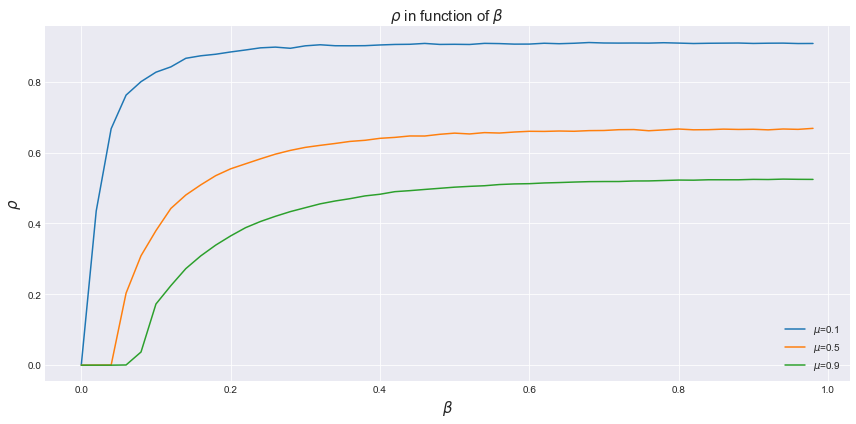

In [30]:
for i in range(len(mu_list)):
    plt.plot(beta_list, values_per_mu[i], label=r'$\mu$' + '={}'.format(mu_list[i]))
    plt.title(r'$\rho$' + ' in function of ' + r'$\beta$', fontsize=15)
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.ylabel(r'$\rho$', fontsize=15)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.style.use('seaborn-darkgrid')